#  KKBox’s Music Recommendation Challenge


## Table of Content

<br> 1. Introduction
<br> 2.Abstract
<br> 3.Table
<br> 4.Import Data
<br> 5.EDA
    * The frequency of user listen to songs
    * Which songs repeated
    * Language of most common songs
    * Most common genre
    * Most common composers
    * Most common lyricist
    * Repeats by system tabs
    * Repeats by screen name
    * User play music source type
    * Listen to the same song by gender
    * Repeat users by city
    * Repeat users by registration mechanism
    * Source type
    * Regigsted_via
<br> 6. Merge and read data
<br> 7.Process Data
    * Process null data
    * Add Gener_count column
    * Add repeat_percentage column
    * Data mergeing and add composer_count feature
    * Replace string value with numbers , add lyricist_count and validity_days feature
    * Transform isrc column to year 
    * Process data types and create age groups

<br> 8. Algotirhm part
    * LightGBM
        * lightgbm param 1
        * lightgbm param 2
        * lightgbm param 3
    * Other Models
        * Naive Bayes
        * Decision Tree
        * LR Models
        * Randoms Forest
<br> 9. Predicting with 10 most important features
<br> 10. Recommendation function
<br> 11. Summary
    

## Introduction

<br>With the development of music diversity, people have their own preferences and favorite songs, singers. KKBOX has an interesting study that predicts whether users will continue to listen to the same song after hearing it once for a month, i.e. the repetition rate of the song. However, how to study this phenomenon and how to use different features and different prediction models to influence this result is worth exploring.

## Abstract

<br>In this PROJECT, the first part is data processing, fill the null values with mode, median, mean or unknown type. Then, for getting a better result, we added features like validity_days, repeat_percentage.. and transform the values in age group, genre_id… Next, we compared the results of several common algorithm. In the last part of the project, there is a simple recommendation system which can return the percentage of a song indicate that whether it should be recommend or not.

### Tables

#### train.csv

* msno: user id
* song_id: song id
* source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
* source_screen_name: name of the layout a user sees.
* source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
* target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

#### test.csv

* id: row id (will be used for submission)
* msno: user id
* song_id: song id
* source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
* source_screen_name: name of the layout a user sees.
* source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc

#### sample_submission.csv
sample submission file in the format that we expect you to submit

* id: same as id in test.csv
* target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

#### songs.csv

The songs. Note that data is in unicode.

* song_id
* song_length: in ms
* genre_ids: genre category. Some songs have multiple genres and they are separated by |
* artist_name
* composer
* lyricist
* language

#### members.csv

user information.

* msno
* city
* bd: age. Note: this column has outlier values, please use your judgement.
* gender
* registered_via: registration method
* registration_init_time: format %Y%m%d
* expiration_date: format %Y%m%d

#### song_extra_info.csv

* song_id
* song name - the name of the song.
* isrc - International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.

## Import Data

In [1]:
import numpy as np
import pandas as pd 
train = pd.read_csv("../input/train.csv")
test=pd.read_csv("../input/test.csv")
members=pd.read_csv("../input/members.csv")
songs=pd.read_csv("../input/songs.csv")
print('train',train.shape)
print('test',test.shape)
print('members',members.shape)
print('songs',songs.shape)

train (7377418, 6)
test (2556790, 6)
members (34403, 7)
songs (2296320, 7)


In [2]:
from pylab import rcParams
import missingno as msno
import seaborn as sns
import warnings
import matplotlib
%matplotlib inline
sns.set(style="ticks")
rcParams['axes.facecolor'] = 'white'
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
matplotlib.style.use('fivethirtyeight') 
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [3]:
rcParams.keys()

['_internal.classic_mode',
 'agg.path.chunksize',
 'animation.avconv_args',
 'animation.avconv_path',
 'animation.bitrate',
 'animation.codec',
 'animation.convert_args',
 'animation.convert_path',
 'animation.ffmpeg_args',
 'animation.ffmpeg_path',
 'animation.frame_format',
 'animation.html',
 'animation.mencoder_args',
 'animation.mencoder_path',
 'animation.writer',
 'axes.autolimit_mode',
 'axes.axisbelow',
 'axes.edgecolor',
 'axes.facecolor',
 'axes.formatter.limits',
 'axes.formatter.offset_threshold',
 'axes.formatter.use_locale',
 'axes.formatter.use_mathtext',
 'axes.formatter.useoffset',
 'axes.grid',
 'axes.grid.axis',
 'axes.grid.which',
 'axes.hold',
 'axes.labelcolor',
 'axes.labelpad',
 'axes.labelsize',
 'axes.labelweight',
 'axes.linewidth',
 'axes.prop_cycle',
 'axes.spines.bottom',
 'axes.spines.left',
 'axes.spines.right',
 'axes.spines.top',
 'axes.titlepad',
 'axes.titlesize',
 'axes.titleweight',
 'axes.unicode_minus',
 'axes.xmargin',
 'axes.ymargin',
 'axes3d

In [4]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
msno                  object
song_id               object
source_system_tab     object
source_screen_name    object
source_type           object
target                int64
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


In [6]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [7]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
msno                      34403 non-null object
city                      34403 non-null int64
bd                        34403 non-null int64
gender                    14501 non-null object
registered_via            34403 non-null int64
registration_init_time    34403 non-null int64
expiration_date           34403 non-null int64
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


In [8]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [9]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
song_id        object
song_length    int64
genre_ids      object
artist_name    object
composer       object
lyricist       object
language       float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


## How many times do the user listen to the song again

In [10]:
print(train.target.value_counts()*100/train.target.value_counts().sum())
print('How many unique songs ',len(train.song_id.unique()))

1    50.351708
0    49.648292
Name: target, dtype: float64
How many unique songs  359966


## Which songs are getting repeated


In [11]:
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 6)
repeats=train[train.target==1]
song_repeats=repeats.groupby('song_id',as_index=False).msno.count()
song_repeats.columns=['song_id','count']



In [12]:
song_repeats=pd.DataFrame(song_repeats).merge(songs,left_on='song_id',right_on='song_id')
print('median length of songs repeated',song_repeats.sort_values(by='count',ascending=False)[:2000].song_length.median())
print('median length of songs repeated',songs.song_length.median())

median length of songs repeated 246647.5
median length of songs repeated 226627.0


In [13]:
print("Top 20 songs repeated")
repeats.song_id.value_counts()[:20]

Top 20 songs repeated


reXuGcEWDDCnL0K3Th//3DFG4S1ACSpJMzA+CFipo1g=    10885
T86YHdD4C9JSc274b1IlMkLuNdz4BQRB50fWWE7hx9g=    10556
FynUyq0+drmIARmK1JZ/qcjNZ7DKkqTY6/0O0lTzNUI=     9808
wBTWuHbjdjxnG1lQcbqnK4FddV24rUhuyrYLd9c/hmk=     9411
PgRtmmESVNtWjoZHO5a1r21vIz9sVZmcJJpFCbRa1LI=     9004
U9kojfZSKaiWOW94PKh1Riyv/zUWxmBRmv0XInQWLGw=     8787
YN4T/yvvXtYrBVN8KTnieiQohHL3T9fnzUkbLWcgLro=     8780
M9rAajz4dYuRhZ7jLvf9RRayVA3os61X/XXHEuW4giA=     8403
43Qm2YzsP99P5wm37B1JIhezUcQ/1CDjYlQx6rBbz2U=     8112
J4qKkLIoW7aYACuTupHLAPZYmRp08en1AEux+GSUzdw=     7903
cy10N2j2sdY/X4BDUcMu2Iumfz7pV3tqE5iEaup2yGI=     7725
750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=     7608
IKMFuL0f5Y8c63Hg9BXkeNJjE0z8yf3gMt/tOxF4QNE=     7224
+SstqMwhQPBQFTPBhLKPT642IiBDXzZFwlzsLl4cGXo=     7061
DLBDZhOoW7zd7GBV99bi92ZXYUS26lzV+jJKbHshP5c=     6901
v/3onppBGoSpGsWb8iaCIO8eX5+iacbH5a4ZUhT7N54=     6879
p/yR06j/RQ2J6yGCFL0K+1R06OeG+eXcwxRgOHDo/Tk=     6536
Xpjwi8UAE2Vv9PZ6cZnhc58MCtl3cKZEO1sdAkqJ4mo=     6399
OaEbZ6TJ1NePtNUeEgWsvFLeopkS

## Artisits of most common songs

We cannot ignore the importance of artists, composer and lyricist, the most popular artists are shown below.

In [14]:
import matplotlib.pyplot as plt    
from wordcloud import WordCloud

def displaywc(txt,title):
    txt=""
    for i in g:
        txt+=str(i)
    wordcloud = WordCloud(background_color='white').generate(txt)

    plt.figure()
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

In [15]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

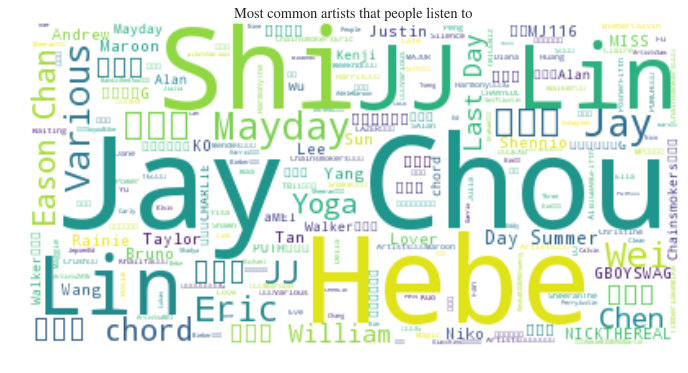

In [16]:
g=song_repeats.sort_values(by='count',ascending=False)[:200].artist_name.tolist()
#TODO Investigate how to display chinese
txt=""
for i in g:
    txt+=str(i)
displaywc(txt,'Most common artists that people listen to ')

It can be seen from this chart, Jay Chou is one of the most popular singer.

## Language of most common songs

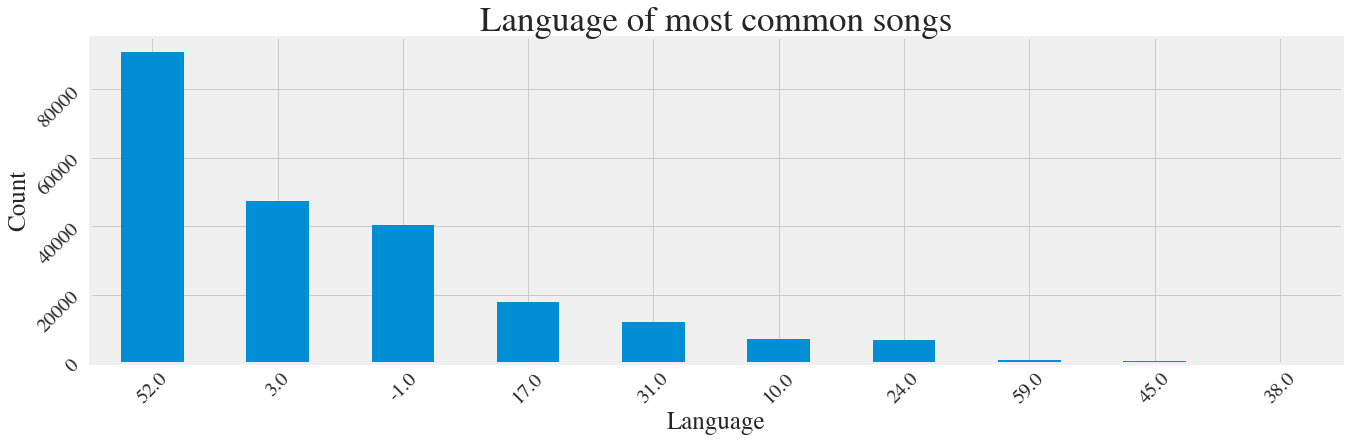

In [17]:
df=pd.DataFrame(song_repeats.sort_values(by='count',ascending=False))
df.language.value_counts().plot(kind='bar')
plt.title('Language of most common songs',fontsize=35)
plt.ylabel('Count',fontsize=25)
plt.xlabel('Language',fontsize=25)
plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=20,rotation=45)
plt.show()

We combining the datasets of songs and members because the number is meaningless for this part. After combining data, compare these two tables. From this bar chart, it can be seen that the 52.0 (English) is the most common language and followed by 3.0 (Chinese).

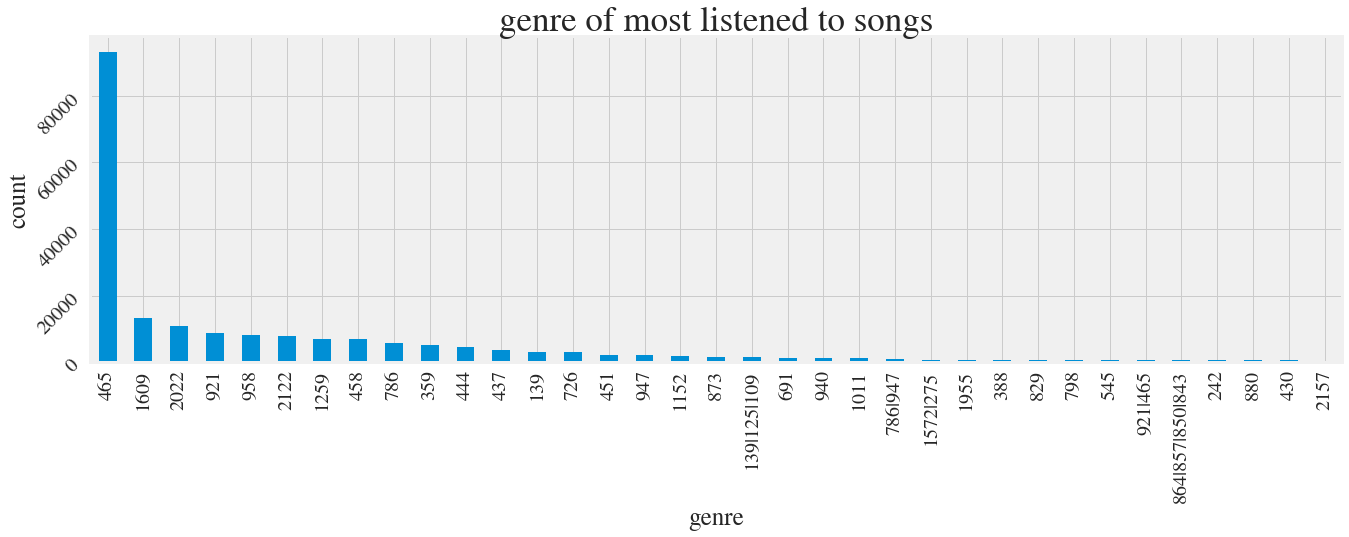

In [18]:
df.genre_ids.value_counts()[:35].plot(kind='bar')
plt.title('genre of most listened to songs',fontsize=35)
plt.xlabel('genre',fontsize=25)
plt.ylabel('count',fontsize=25)
plt.yticks(fontsize=20,rotation=45)
plt.xticks(fontsize=20)
plt.show()

The type of songs is usually important for a person who loves to listen to the songs. For this part, it shows that the most popular genre of songs is 456.

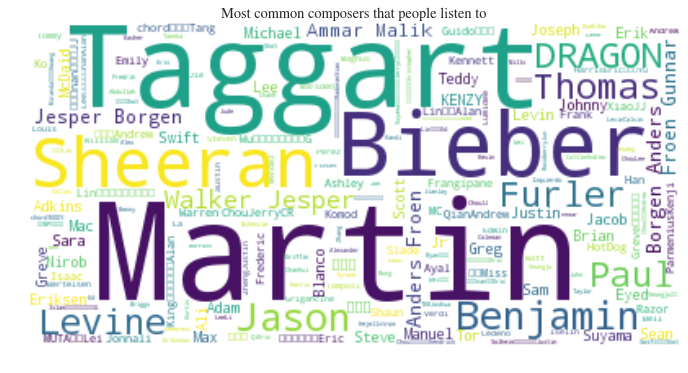

In [19]:
g=song_repeats.sort_values(by='count',ascending=False)[:200].composer.tolist()
#TODO Investigate how to display chinese
txt=""
for i in g:
    txt+=str(i)
displaywc(txt,'Most common composers that people listen to ')

For this diagram, we can notice that Martin is one of the most popular composer who people like to listen to, and followed by Taggart and Bieber.

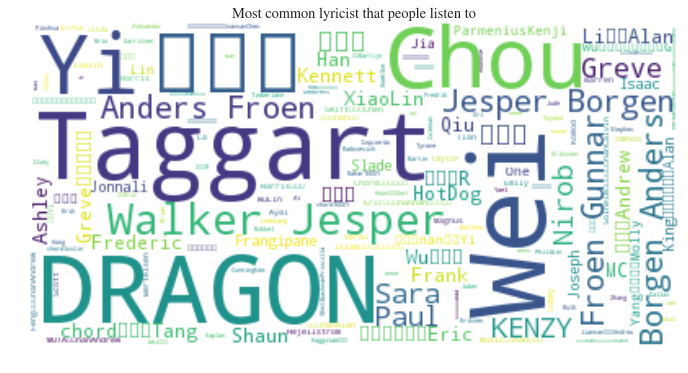

In [20]:
g=song_repeats.sort_values(by='count',ascending=False)[:200].lyricist.tolist()
#TODO Investigate how to display chinese
txt=""
for i in g:
    txt+=str(i)
displaywc(txt,'Most common lyricist that people listen to ')

For this diagram, we can notice that Dragon and Taggart are the most popular lyricist who people like to listen to.

In [21]:
print('Users that listen to the same song again and again')
repeats.msno.value_counts()[:10]

Users that listen to the same song again and again


o+5RNlSWrzvrphgBNGIo1FLkGxBgyICns6qXj3nS7Pk=    3288
KGXNZ/H3VxvET/+rGxlrAe7Gpz2eKMXyuSg3xh8Ij1M=    2818
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=    2791
MXIMDXO0j3UpaT7FvOSGW6Y5zfhlh+xYjTqGoUdMzEE=    2069
dU4RbzpIRRd/EkA9Xncpy9CglzDBZp7nKMfdnfr3Aj8=    1978
4DlS5LiANEKlMTQD08dakyV1JWwPYI/n1wyjx4ImjPc=    1814
JkQacE3rvmhh65R04eDLbu+M7MCkpzmHwMGrbZo0puc=    1806
uCDJmSDTzA5PpnYGqKvNmFbwBIoS3jIXFbO5YfoCv/Y=    1794
1wiu2UfN0BNhHfPTrDS3S/rQkX/vnwDoKH6ODTUdH9k=    1737
cqjRBV/jWN2ujhc+z/4tz+Mj6xEfflAAt6qBXCqxKvw=    1735
Name: msno, dtype: int64

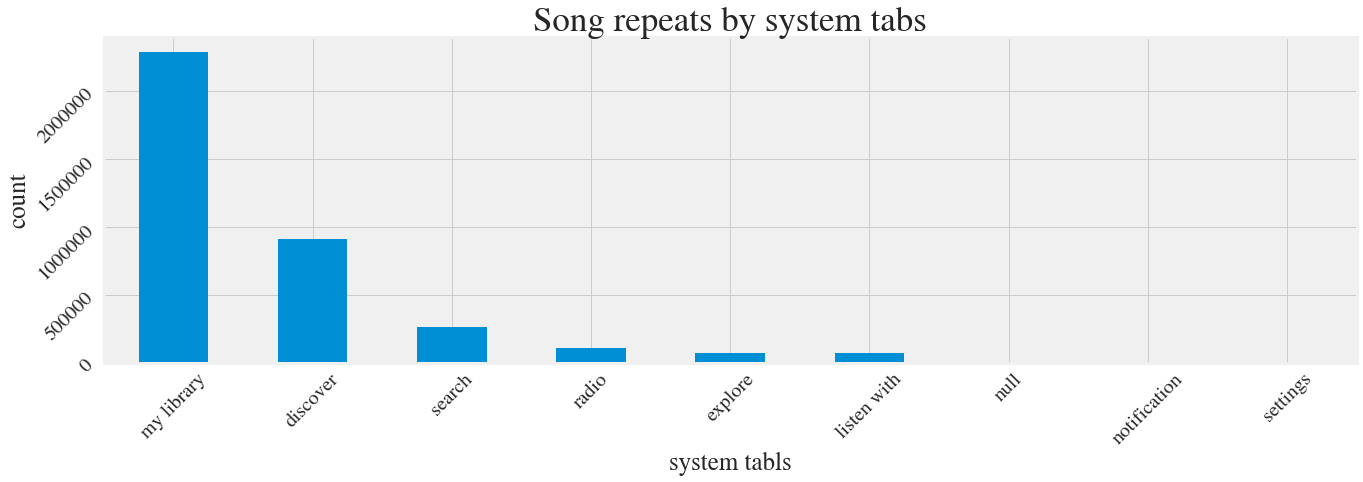

In [22]:
repeats.source_system_tab.value_counts().plot(kind='bar')
#the name of the tab where the event was triggered. 
#System tabs are used to categorize KKBOX mobile apps functions.
#For example, tab my library contains functions to manipulate the local storage, 
#and tab search contains functions relating to search.
plt.title('Song repeats by system tabs',fontsize=35)
plt.xlabel('system tabls',fontsize=25)
plt.ylabel('count',fontsize=25)
plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=20,rotation=45)
plt.show()

If a user likes to listen to songs very much, what types of system tabs do he/she usually using to search for songs? Through this bar chart, we can see that 'my library' is most system tab which user usually like to use.

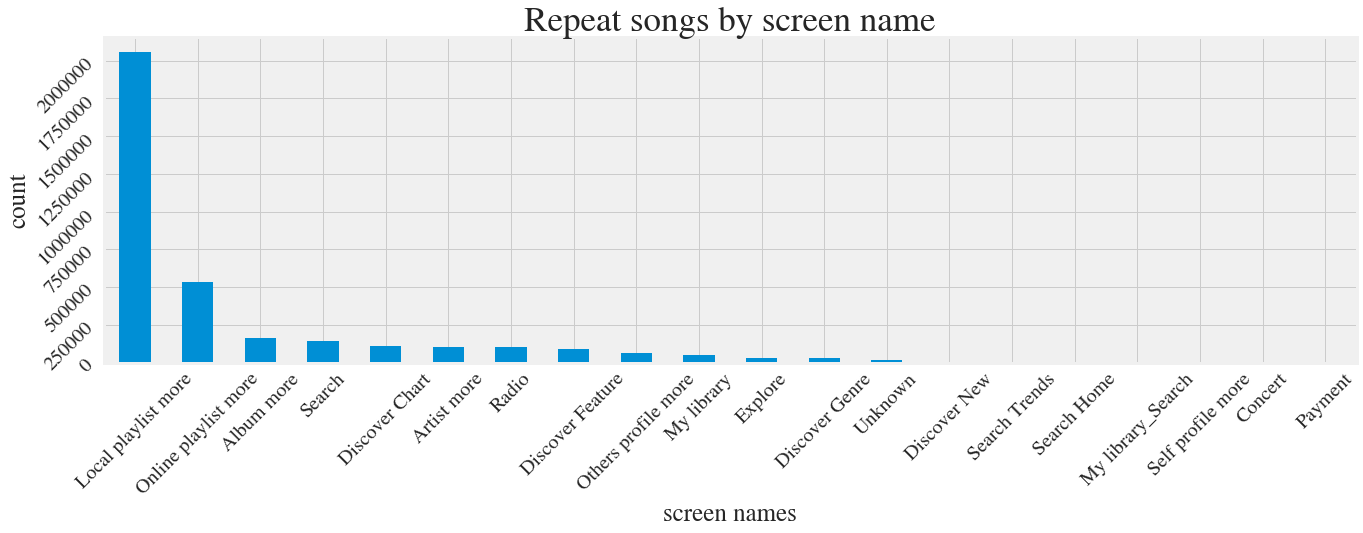

In [23]:
#source_screen_name: name of the layout a user sees. 
repeats.source_screen_name.value_counts().plot(kind='bar')
plt.title('Repeat songs by screen name',fontsize=35)
plt.xlabel('screen names',fontsize=25)
plt.ylabel('count',fontsize=25)
plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=20,rotation=45)
plt.show()

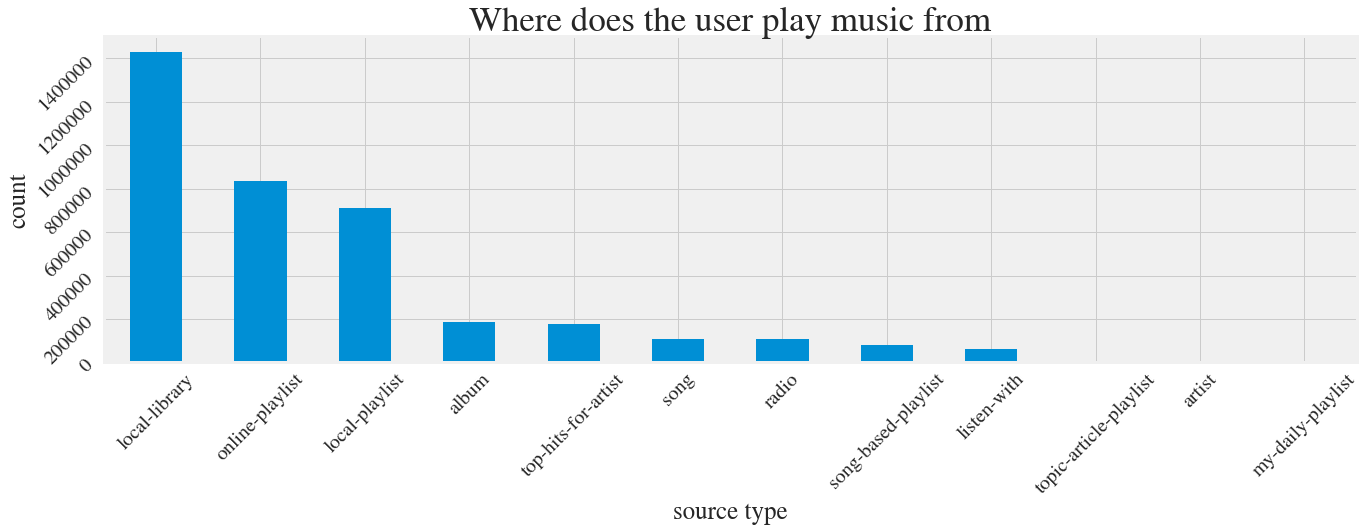

In [24]:

#source_type: an entry point a user first plays music on mobile apps. 
#An entry point could be album, online-playlist, song .. etc. 
repeats.source_type.value_counts().plot(kind='bar')
plt.title('Where does the user play music from',fontsize=35)
plt.xlabel('source type',fontsize=25)
plt.ylabel('count',fontsize=25)
plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=20,rotation=45)
plt.show()


In [25]:
user_repeats=repeats.merge(members,left_on='msno',right_on='msno',how='left')
print("users who repeat")
user_repeats.msno.value_counts()[:20]

users who repeat


o+5RNlSWrzvrphgBNGIo1FLkGxBgyICns6qXj3nS7Pk=    3288
KGXNZ/H3VxvET/+rGxlrAe7Gpz2eKMXyuSg3xh8Ij1M=    2818
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=    2791
MXIMDXO0j3UpaT7FvOSGW6Y5zfhlh+xYjTqGoUdMzEE=    2069
dU4RbzpIRRd/EkA9Xncpy9CglzDBZp7nKMfdnfr3Aj8=    1978
4DlS5LiANEKlMTQD08dakyV1JWwPYI/n1wyjx4ImjPc=    1814
JkQacE3rvmhh65R04eDLbu+M7MCkpzmHwMGrbZo0puc=    1806
uCDJmSDTzA5PpnYGqKvNmFbwBIoS3jIXFbO5YfoCv/Y=    1794
1wiu2UfN0BNhHfPTrDS3S/rQkX/vnwDoKH6ODTUdH9k=    1737
cqjRBV/jWN2ujhc+z/4tz+Mj6xEfflAAt6qBXCqxKvw=    1735
7xiBI5xU3P2/IiR9teB7jySfzWo96JGikGajteLd3Cs=    1715
HVcWdf8CEo9s6qwt5V7TpoPYJfRlQSTA6b7kxEAImpc=    1710
mDJCU+fKu/mbdk9l4SmPYiJwpeMyK44o9wmG1X3735A=    1607
V39VxDdE9SgMQZnX58oQChm9W056pw2lC3TiifMfkKw=    1602
LThaiVqGGnVTPmTcmwN/LLo4fVb5dzkduzd7s1SgzIA=    1578
EZmIP7zKgqKwpEHnuDjRIkzCmcLNlHn4hkiglZ5LxK8=    1539
00qmlWC3H/cjf2Ig1li5xIO0VNDRgBX0f9ilouDBEZs=    1533
x+k/zTEqdgYq6O+r1iDjKRaQnaCS5118gzBe8c12r1Y=    1503
K7obY5lUlZTd6a/byE9NG/e7Q/dlgHfppLbYk8OL7os=  

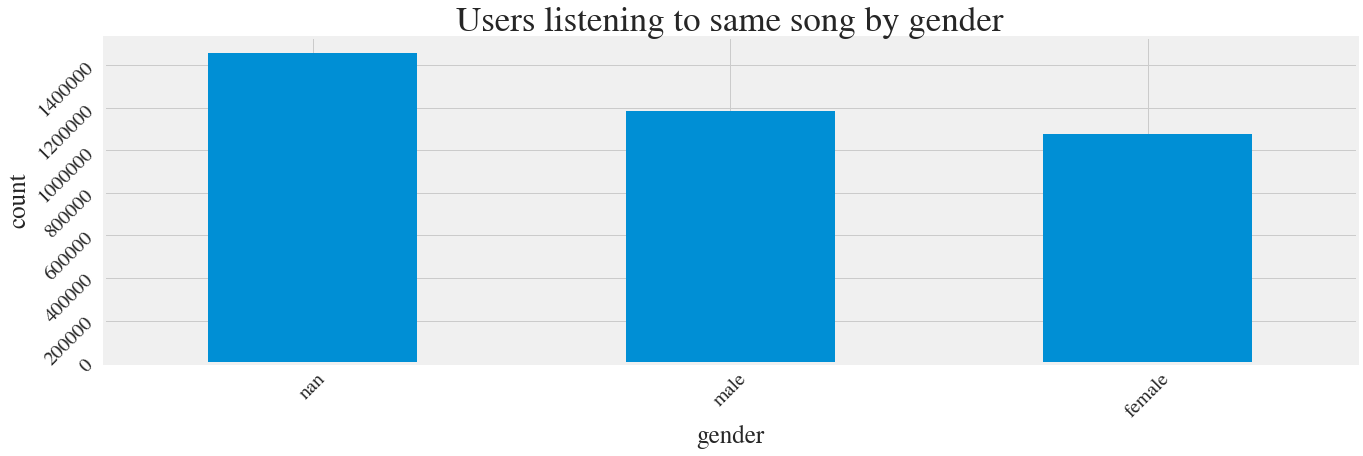

In [26]:
user_repeats.gender.value_counts(dropna=False).plot(kind='bar')
plt.title('Users listening to same song by gender',fontsize=35)
plt.xlabel('gender',fontsize=25)
plt.ylabel("count",fontsize=25)
plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=20,rotation=45)
plt.show()


As we all know, a lot of people like listening to the music to relax. So what is the distribution of the number of males and females listening to songs? We can see from this histogram that the number of males and females listening to songs are basically the same.

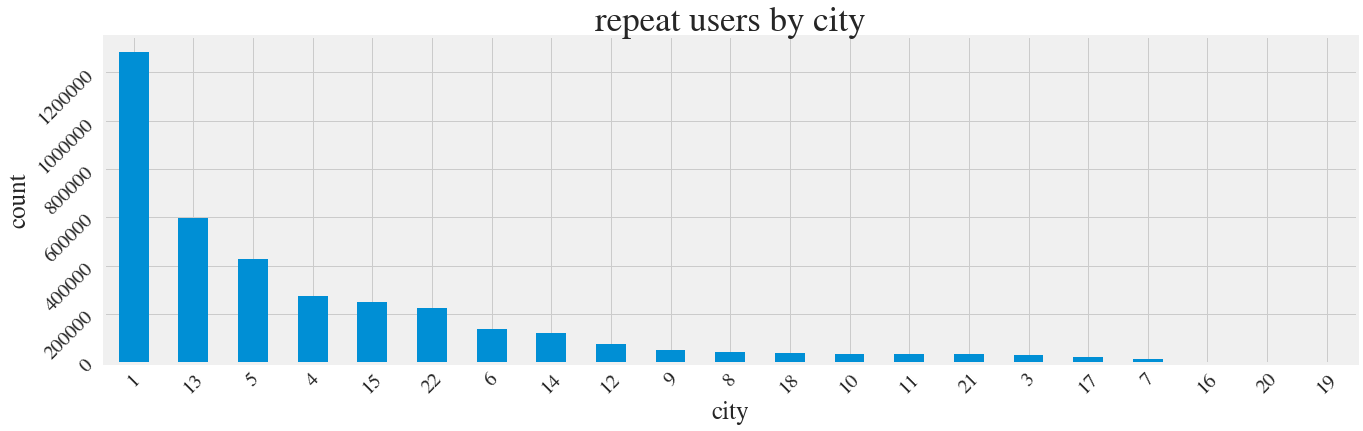

In [27]:
user_repeats.city.value_counts().plot(kind='bar')
plt.title('repeat users by city',fontsize=35)
plt.xlabel('city',fontsize=25)
plt.ylabel('count',fontsize=25)
plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=20,rotation=45)
plt.show()

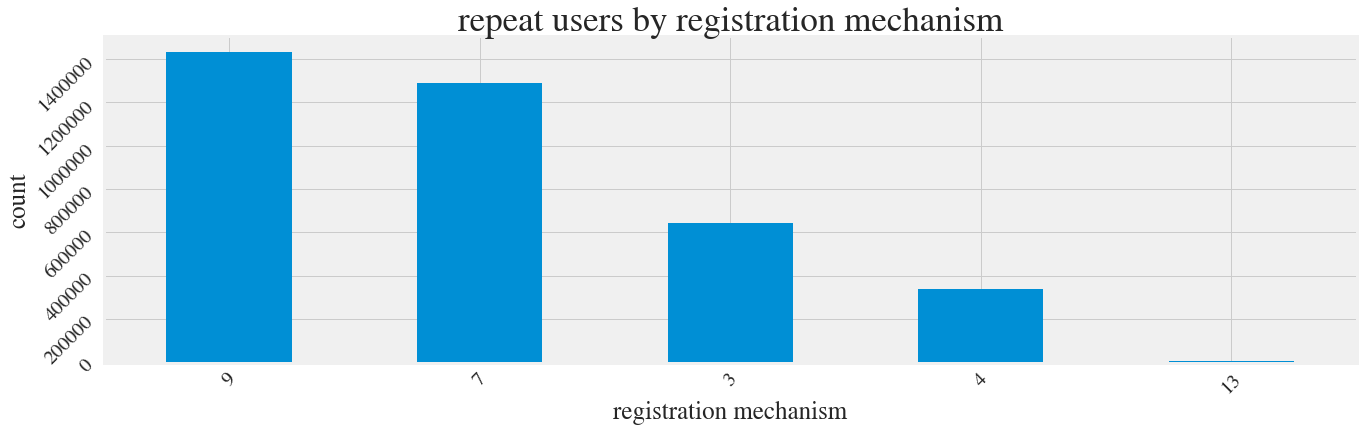

In [28]:
user_repeats.registered_via.value_counts().plot(kind='bar')
plt.title('repeat users by registration mechanism',fontsize=35)
plt.xlabel('registration mechanism',fontsize=25)
plt.ylabel('count',fontsize=25)
plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=20,rotation=45)
plt.show()

In [30]:
df_train_members = pd.merge(train, members, on='msno', how='inner')
df_train_merged = pd.merge(df_train_members, songs, on='song_id', how='outer')

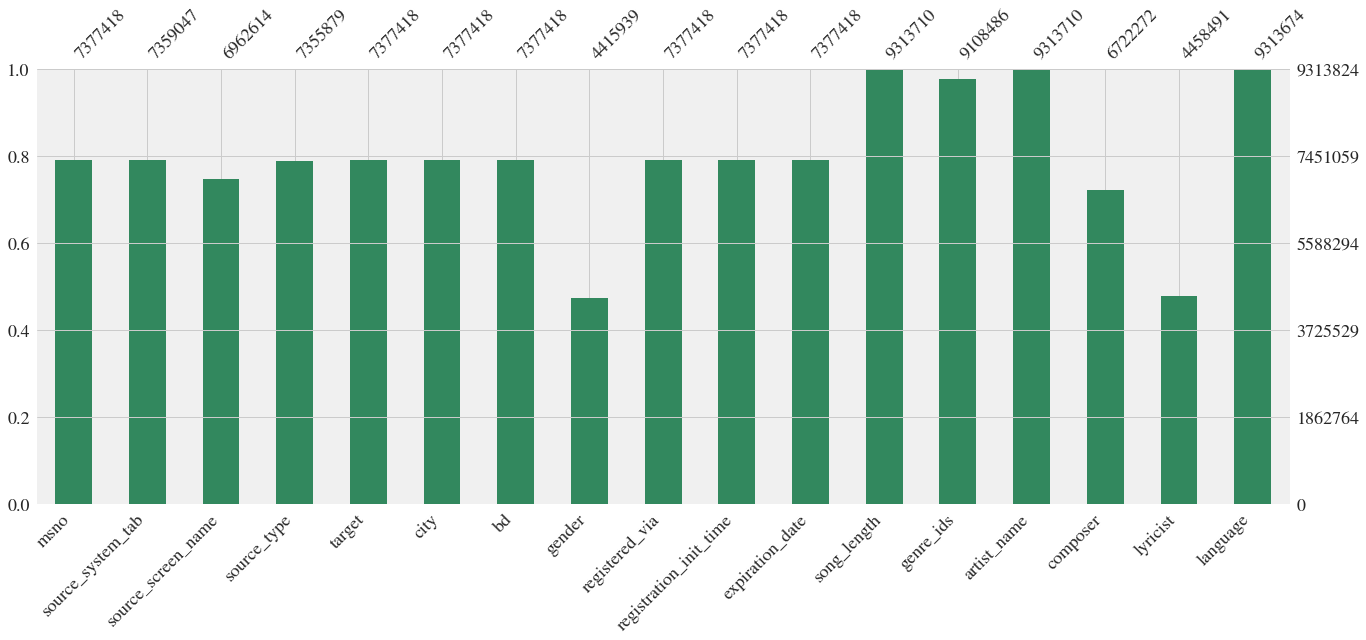

In [31]:
msno.bar(df_train_merged[df_train_merged.columns[df_train_merged.isnull().any()].tolist()],figsize=(20,8),color="#32885e",fontsize=18,labels=True,)

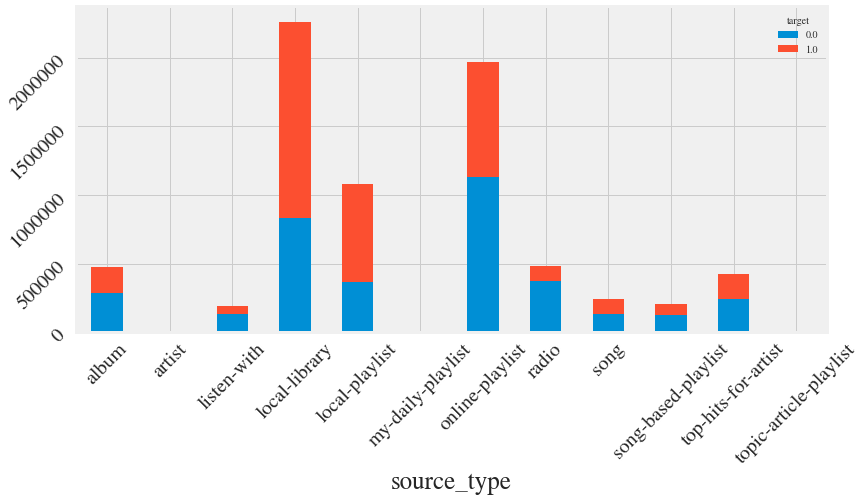

In [46]:
ct = pd.crosstab(df_train_merged.source_type, df_train_merged.target)
ct.plot.bar(figsize = (12, 6), stacked=True)
plt.xlabel('source_type',fontsize=25)
plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=20,rotation=45)
plt.show()

The distribution of target value in different tabs

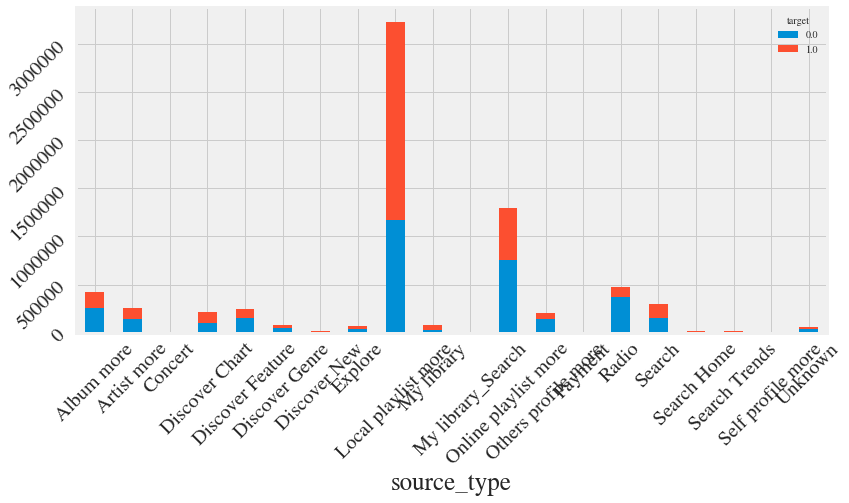

In [51]:
ct = pd.crosstab(df_train_merged.source_screen_name, df_train_merged.target)
ct.plot.bar(figsize = (12, 6), stacked=True)
plt.xlabel('source_type',fontsize=25)
plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=20,rotation=45)
plt.show()

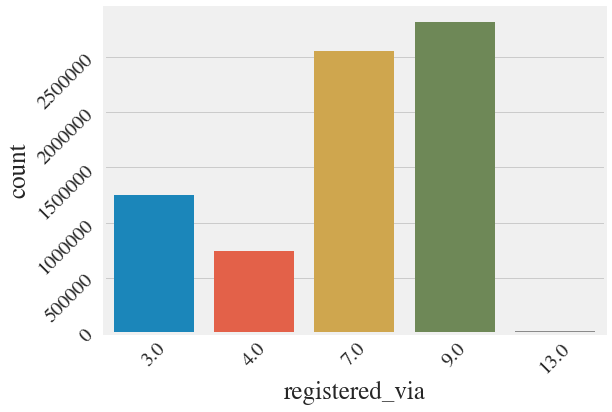

In [53]:
plt.figure(figsize = (8, 6))
ax = sns.countplot(x = "registered_via", data = df_train_merged)
plt.ylabel('count',fontsize=25)
plt.xlabel('registered_via',fontsize=25)
plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=20,rotation=45)
plt.show()

## This is the end of EDA

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Python libraries
from sklearn import cross_validation, grid_search, metrics, ensemble
#import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import copy as cp
plt.style.use('ggplot')

/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Read csv

In [3]:
df_train = pd.read_csv("../input/train.csv")
df_songs = pd.read_csv("../input/songs.csv")
df_songs_extra = pd.read_csv("../input/song_extra_info.csv")
df_members = pd.read_csv("../input/members.csv",parse_dates=["registration_init_time","expiration_date"])
df_test = pd.read_csv("../input/test.csv")

Merging all the data together

In [4]:
df_train =df_train.merge(df_songs,how="left",on="song_id")
df_train = df_train.merge(df_members,how="left",on="msno")
df_test =df_test.merge(df_songs,how="left",on="song_id")
df_test = df_test.merge(df_members,how="left",on="msno")
train_ori = cp(df_train)
test_ori = cp(df_test)

# **Handling Null Values **

     gender, source_system_tab, source_screen_name, source_type, genre_ids,artist_name, composer and lyricist are filled wiht "Unknown" type, song_length and language are filled with mean and mode.

In [5]:
df_train['gender'].fillna(value="Unknown",inplace=True)
df_test['gender'].fillna(value="Unknown",inplace=True)

df_train['source_system_tab'].fillna(value="Unknown",inplace=True)
df_test['source_system_tab'].fillna(value="Unknown",inplace=True)

df_train['source_screen_name'].fillna(value="Unknown",inplace=True)
df_test['source_screen_name'].fillna(value="Unknown",inplace=True)

df_train['source_type'].fillna(value="Unknown",inplace=True)
df_test['source_type'].fillna(value="Unknown",inplace=True)

df_train['genre_ids'].fillna(value="Unknown",inplace=True)
df_test['genre_ids'].fillna(value="Unknown",inplace=True)

df_train['artist_name'].fillna(value="Unknown",inplace=True)
df_test['artist_name'].fillna(value="Unknown",inplace=True)

df_train['composer'].fillna(value="Unknown",inplace=True)
df_test['composer'].fillna(value="Unknown",inplace=True)

df_train['lyricist'].fillna(value="Unknown",inplace=True)
df_test['lyricist'].fillna(value="Unknown",inplace=True)

df_train['song_length'].fillna(value=df_train['song_length'].mean(),inplace=True)
df_test['song_length'].fillna(value=df_test['song_length'].mean(),inplace=True)

df_train['language'].fillna(value=df_train['language'].mode()[0],inplace=True)
df_test['language'].fillna(value=df_test['language'].mode()[0],inplace=True)

### Genre_count feature
Single/muti-genre tab may influence user’s choice. Therefore,we need a genre_count column. 

In [6]:
df_train['genre_ids'] = df_train['genre_ids'].str.split("|")
df_test['genre_ids'] = df_test['genre_ids'].str.split("|")

df_train['genre_count'] = df_train['genre_ids'].apply(lambda x : len(x) if "Unknown" not in x else 0)
df_test['genre_count'] = df_test['genre_ids'].apply(lambda x : len(x) if "Unknown" not in x else 0)

In [7]:
df_train['artist_name'].nunique()

40583

In [8]:
df_test['artist_name'].nunique()

27564

<br> Check all individual songs to make sure all songs are unduplicated and analyzable.

In [9]:
print("Number of Common Artists in both train & Test : ", len(set.intersection(set(df_train['artist_name']), set(df_test['artist_name']))))

Number of Common Artists in both train & Test :  21774


## repeat_percentage feature

We made an assumption that not only the song itself, but also the artists and composers have an impact on whether a song will be repeat or not. For example, songs from world-class singer are more likely be added to users’ favorite. In that way, we calculated how many times the artists’ and composers’ songs are played and the times they were repeat, then get the percentage of repeating. Repeat_percentage will replace the artist and composer columns.

In [10]:

df_artists = df_train.loc[:,["artist_name","target"]]

artists1 = df_artists.groupby(["artist_name"],as_index=False).sum().rename(columns={"target":"repeat_count"})

artists2 = df_artists.groupby(["artist_name"],as_index=False).count().rename(columns = {"target":"play_count"})
df_artist_repeats = artists1.merge(artists2,how="inner",on="artist_name")

In [11]:
df_artist_repeats.head()

,artist_name,repeat_count,play_count
0,!Conz,1,1
1,!magnic!,0,1
2,#037 (#037),20,84
3,#1 Beatles Now,7,32
4,#1 Club Hits - Best Of Dance & Techno,5,7


In [12]:
df_artist_repeats["repeat_percentage"] = round((df_artist_repeats['repeat_count']*100) / df_artist_repeats['play_count'],1)

In [13]:
df_artist_repeats.head()

,artist_name,repeat_count,play_count,repeat_percentage
0,!Conz,1,1,100.0
1,!magnic!,0,1,0.0
2,#037 (#037),20,84,23.8
3,#1 Beatles Now,7,32,21.9
4,#1 Club Hits - Best Of Dance & Techno,5,7,71.4


In [14]:
df_artist_repeats.drop(["repeat_count","play_count"],axis=1,inplace=True)

## data mergeing and composer_count feature

In [15]:
df_train = df_train.merge(df_artist_repeats,on="artist_name",how="left").rename(columns={"repeat_percentage":"artist_repeat_percentage"})
df_test = df_test.merge(df_artist_repeats,on="artist_name",how="left").rename(columns={"repeat_percentage":"artist_repeat_percentage"})

df_train.drop(["genre_ids","artist_name"],axis=1,inplace=True)
df_test.drop(["genre_ids","artist_name"],axis=1,inplace=True)

del df_artist_repeats
del df_artists

df_train['composer'] = df_train['composer'].str.split("|") 
df_test['composer'] = df_test['composer'].str.split("|") 

df_train['composer_count'] = df_train['composer'].apply(lambda x : len(x) if "Unknown" not in x else 0 )
df_test['composer_count'] = df_test['composer'].apply(lambda x : len(x) if "Unknown" not in x else 0 )

df_train['source_system_tab'].value_counts()

my library      3684730
discover        2179252
search           623286
radio            476701
listen with      212266
explore          167949
Unknown           18371
null               6478
notification       6185
settings           2200
Name: source_system_tab, dtype: int64

## Replace string value with numbers ,lyricist_count and validity_days feature

Use map function to replace the string values with numbers. The feature validity_days represents how long users have paid for the membership. 

In [16]:

source_tab_dict = {"my library":8,"discover":7,"search":6,"radio":5,"listen with":4,"explore":3,"notification":2,"settings":1,"Unknown":0 }
source_screen_name_dict = {"Local playlist more":19,"Online playlist more":18,"Radio":17,"Unknown":16,"Album more":15,"Search":14,"Artist more":13,"Discover Feature":12,"Discover Chart":11,"Others profile more":10,"Discover Genre":9,"My library":8,"Explore":7,"Discover New":6,"Search Trends":5,"Search Home":4,"My library_Search":3,"Self profile more":2,"Concert":1,"Payment":0}
source_type_dict = {"local-library":12,"online-playlist":11,"local-playlist":10,"radio":9,"album":8,"top-hits-for-artist":7,"song":6,"song-based-playlist":5,"listen-with":4,"Unknown":3,"topic-article-playlist":2,"artist":1,"my-daily-playlist":0}
df_train['source_system_tab'] = df_train['source_system_tab'].map(source_tab_dict)
df_test['source_system_tab'] = df_test['source_system_tab'].map(source_tab_dict)
df_train['source_type'] = df_train['source_type'].map(source_type_dict)
df_test['source_type'] = df_test['source_type'].map(source_type_dict)
df_train['source_screen_name'] = df_train['source_screen_name'].map(source_screen_name_dict)
df_test['source_screen_name'] = df_test['source_screen_name'].map(source_screen_name_dict)
gender_train = pd.get_dummies(df_train['gender'],drop_first=True)
gender_test = pd.get_dummies(df_test['gender'],drop_first=True)
df_train = pd.concat([df_train,gender_train],axis=1)
df_test = pd.concat([df_test,gender_test],axis=1)
df_train.drop(["composer","gender"],axis=1,inplace=True)
df_test.drop(["composer","gender"],axis=1,inplace=True)
df_train['validity_days'] = (df_train['expiration_date'] - df_train['registration_init_time']).dt.days
df_test['validity_days'] = (df_test['expiration_date'] - df_test['registration_init_time']).dt.days
df_train.drop(["registration_init_time","expiration_date"],axis=1,inplace=True)
df_test.drop(["registration_init_time","expiration_date"],axis=1,inplace=True)
df_train['lyricist'] = df_train['lyricist'].str.split("|")
df_test['lyricist'] = df_test['lyricist'].str.split("|")
df_train['lyricist_count'] = df_train['lyricist'].apply(lambda x : len(x) if "Unknown" not in x else 0 )
df_test['lyricist_count'] = df_test['lyricist'].apply(lambda x : len(x) if "Unknown" not in x else 0 )
df_test['artist_repeat_percentage'].fillna(value=0.0,inplace=True)
df_test['source_screen_name'].fillna(df_test['source_screen_name'].mode()[0],inplace=True)
df_train.drop("lyricist",axis=1,inplace=True)
df_test.drop("lyricist",axis=1,inplace=True)
df_songs_extra.drop("name",axis=1,inplace=True)

df_train = df_train.merge(df_songs_extra,how="left",on="song_id")
df_test = df_test.merge(df_songs_extra,how="left",on="song_id")

## Transform isrc to year 

In [17]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan

## Process data types and create age groups

<br> By defining functions to process the year's data, the results can be more accurate. In order to simplify the features. We first divide the age into 7 groups from -45 to over 80.(-45 to 0 are missing values，and will be replaced by category 5)

In [18]:

df_train['song_year'] = df_train['isrc'].apply(isrc_to_year)
df_test['song_year'] = df_test['isrc'].apply(isrc_to_year)

df_train.drop("isrc",axis=1,inplace=True)
df_test.drop("isrc",axis=1,inplace=True)

df_train['song_year'].fillna(value=-1,inplace=True)
df_test['song_year'].fillna(value=-1,inplace=True)

df_train['song_year'] = df_train['song_year'].astype("int")
df_test['song_year'] = df_test['song_year'].astype("int")
df_train['source_system_tab'] = df_train['source_system_tab'].astype("category")
df_test['source_system_tab'] = df_test['source_system_tab'].astype("category")
df_train['source_screen_name'] = df_train['source_screen_name'].astype("category")
df_test['source_screen_name'] = df_test['source_screen_name'].astype("category")
df_train['source_type'] = df_train['source_type'].astype("category")
df_test['source_type'] = df_test['source_type'].astype("category")
df_train['language'] = df_train['language'].astype("category")
df_test['language'] = df_test['language'].astype("category")
df_train['city'] = df_train['city'].astype("category")
df_test['city'] = df_test['city'].astype("category")
df_train['registered_via'] = df_train['registered_via'].astype("category")
df_test['registered_via'] = df_test['registered_via'].astype("category")

df_train['age_range'] = pd.cut(df_train['bd'],bins=[-45,0,10,18,35,50,80,1052])
df_test['age_range'] = pd.cut(df_test['bd'],bins=[-45,0,10,18,35,50,80,1052])

combine = [df_train, df_test]

for dataset in combine : 
    
    dataset.loc[(dataset['bd'] > 0) & (dataset['bd'] <= 10), 'age_category'] = 0
    dataset.loc[(dataset['bd'] > 80) & (dataset['bd'] <= 1052), 'age_category'] = 1
    dataset.loc[(dataset['bd'] > 50) & (dataset['bd'] <= 80), 'age_category'] = 2
    dataset.loc[(dataset['bd'] > 10) & (dataset['bd'] <= 18), 'age_category'] = 3
    dataset.loc[(dataset['bd'] > 35) & (dataset['bd'] <= 50), 'age_category'] = 4
    dataset.loc[(dataset['bd'] > -45) & (dataset['bd'] <= 0), 'age_category'] = 5
    dataset.loc[(dataset['bd'] > 18) & (dataset['bd'] <= 35), 'age_category'] = 6

In [19]:
df_train.drop(["age_range","bd"],axis=1,inplace=True)
df_test.drop(["age_range","bd"],axis=1,inplace=True)

## Algotirhm part
We made comparison through different common algorithms, and for every algorithm we repeat for several times and use the average result as final result.

## Lightgbm
we adjust the parameters inodrer to get a better result

In [20]:
X = df_train.drop(["msno","song_id","target"],axis=1).values
columns = df_train.drop(["msno","song_id","target"],axis=1).columns
y = df_train['target'].values
song_ids = df_test['id'].values

X_test = df_test.drop(["msno","song_id","id"],axis=1).values

In [21]:
import lightgbm as lgb

d_train = lgb.Dataset(X, y)
watchlist = [d_train]

### lightgbm param 1

In [22]:
params = {}
params['learning_rate'] = 0.5
params['application'] = 'binary'
params['max_depth'] = 10
params['num_leaves'] = 2**6
params['verbosity'] = 0
params['metric'] = 'auc'

In [23]:
model = lgb.train(params, train_set=d_train, num_boost_round=100, valid_sets=watchlist, \
verbose_eval=5)

[5]	training's auc: 0.690779
[10]	training's auc: 0.695554
[15]	training's auc: 0.699846
[20]	training's auc: 0.702386
[25]	training's auc: 0.705729
[30]	training's auc: 0.707667
[35]	training's auc: 0.709715
[40]	training's auc: 0.712117
[45]	training's auc: 0.714096
[50]	training's auc: 0.715747
[55]	training's auc: 0.71706
[60]	training's auc: 0.718624
[65]	training's auc: 0.71969
[70]	training's auc: 0.720722
[75]	training's auc: 0.721742
[80]	training's auc: 0.722762
[85]	training's auc: 0.724261
[90]	training's auc: 0.725294
[95]	training's auc: 0.726141
[100]	training's auc: 0.726994


In [40]:
y_preds = model.predict(X_test)
result_df = pd.DataFrame()
result_df['id'] = song_ids
result_df['target'] = y_preds
result_df.to_csv('submission1.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

### lightgbm param 2

In [41]:
params = {}
params['learning_rate'] = 0.2
params['application'] = 'binary'
params['max_depth'] = 60
params['num_leaves'] = 2**6
params['verbosity'] = 0
params['metric'] = 'auc'

In [42]:
model = lgb.train(params, train_set=d_train, num_boost_round=200, valid_sets=watchlist, \
verbose_eval=5)

[5]	training's auc: 0.687526
[10]	training's auc: 0.690338
[15]	training's auc: 0.693165
[20]	training's auc: 0.695593
[25]	training's auc: 0.697991
[30]	training's auc: 0.699646
[35]	training's auc: 0.701187
[40]	training's auc: 0.702632
[45]	training's auc: 0.704353
[50]	training's auc: 0.705461
[55]	training's auc: 0.706787
[60]	training's auc: 0.708119
[65]	training's auc: 0.709092
[70]	training's auc: 0.709969
[75]	training's auc: 0.71098
[80]	training's auc: 0.711685
[85]	training's auc: 0.712223
[90]	training's auc: 0.713114
[95]	training's auc: 0.713937
[100]	training's auc: 0.714569
[105]	training's auc: 0.715348
[110]	training's auc: 0.716225
[115]	training's auc: 0.717168
[120]	training's auc: 0.717938
[125]	training's auc: 0.718454
[130]	training's auc: 0.718932
[135]	training's auc: 0.719523
[140]	training's auc: 0.720277
[145]	training's auc: 0.720829
[150]	training's auc: 0.721741
[155]	training's auc: 0.722124
[160]	training's auc: 0.722742
[165]	training's auc: 0.7232


In [43]:
y_preds = model.predict(X_test)
result_df = pd.DataFrame()
result_df['id'] = song_ids
result_df['target'] = y_preds
result_df.to_csv('submission2.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

### lightgbm param 3

In [44]:
params = {}
params['learning_rate'] = 0.2
params['application'] = 'binary'
params['max_depth'] = 60
params['num_leaves'] = 2**8
params['verbosity'] = 0
params['metric'] = 'auc'

In [45]:
model = lgb.train(params, train_set=d_train, num_boost_round=200, valid_sets=watchlist, \
verbose_eval=5)

[5]	training's auc: 0.695166
[10]	training's auc: 0.699812
[15]	training's auc: 0.703612
[20]	training's auc: 0.709553
[25]	training's auc: 0.71352
[30]	training's auc: 0.717292
[35]	training's auc: 0.721096
[40]	training's auc: 0.723342
[45]	training's auc: 0.726398
[50]	training's auc: 0.729199
[55]	training's auc: 0.730765
[60]	training's auc: 0.732648
[65]	training's auc: 0.734282
[70]	training's auc: 0.735606
[75]	training's auc: 0.736766
[80]	training's auc: 0.738135
[85]	training's auc: 0.739615
[90]	training's auc: 0.74094
[95]	training's auc: 0.7418
[100]	training's auc: 0.742803
[105]	training's auc: 0.743663
[110]	training's auc: 0.744859
[115]	training's auc: 0.745772
[120]	training's auc: 0.746769
[125]	training's auc: 0.748094
[130]	training's auc: 0.748869
[135]	training's auc: 0.750061
[140]	training's auc: 0.750882
[145]	training's auc: 0.751704
[150]	training's auc: 0.752892
[155]	training's auc: 0.753863
[160]	training's auc: 0.755246
[165]	training's auc: 0.756015
[

In [46]:
y_preds = model.predict(X_test)
result_df = pd.DataFrame()
result_df['id'] = song_ids
result_df['target'] = y_preds
result_df.to_csv('submission3.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

## Other models

Other models need more data operate

In [21]:
for column in list(df_train.columns[df_train.isnull().sum() > 0]):
    df_train[column]=df_train[column].astype('float')
    mean_val = df_train[column].mean()
    df_train[column].fillna(mean_val, inplace=True)
for column in list(df_test.columns[df_test.isnull().sum() > 0]):
    df_test[column]=df_test[column].astype('float')
    mean_val = df_test[column].mean()
    df_test[column].fillna(mean_val, inplace=True)

In [23]:
X = df_train.drop(["msno","song_id","target"],axis=1).values
columns = df_train.drop(["msno","song_id","target"],axis=1).columns
y = df_train['target'].values
song_ids = df_test['id'].values

X_test = df_test.drop(["msno","song_id","id"],axis=1).values

## Naive Bayes

In [67]:
def nb_pre(X,y,P,NFOLDS=2):
    predictions = np.zeros(len(P))
    for fold_ in range(NFOLDS):
        estimator = GaussianNB()
        print(fold_)
        estimator.fit(X,y)
        pp_p = estimator.predict(P)
        
        predictions += pp_p/NFOLDS
    print('done')
    
    return predictions

In [50]:
from sklearn.naive_bayes import GaussianNB
y_preds = nb_pre(X,y,X_test,NFOLDS=10)
result_df = pd.DataFrame()
result_df['id'] = song_ids
result_df['target'] = y_preds
result_df.to_csv('NB.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

0
1
2
3
4
5
6
7
8
9
done


## Decision Tree

In [28]:
def dt_pre(X,y,P,NFOLDS=2):
    predictions = np.zeros(len(P))
    for fold_ in range(NFOLDS):
        estimator = DecisionTreeClassifier()
        print(fold_)
        estimator.fit(X,y)
        pp_p = estimator.predict(P)
        
        predictions += pp_p/NFOLDS
    print('done')
    
    return predictions,estimator

In [29]:
from sklearn.tree import DecisionTreeClassifier
y_preds,estimator = dt_pre(X,y,X_test,NFOLDS=10)
result_df = pd.DataFrame()
result_df['id'] = song_ids
result_df['target'] = y_preds
result_df.to_csv('DT.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

0
1
2
3
4
5
6
7
8
9
done


In [24]:
len(columns)

16

#### Find important features By Decision tree

From the decision tree import_feature_ function, it return the most important 10 features.
    

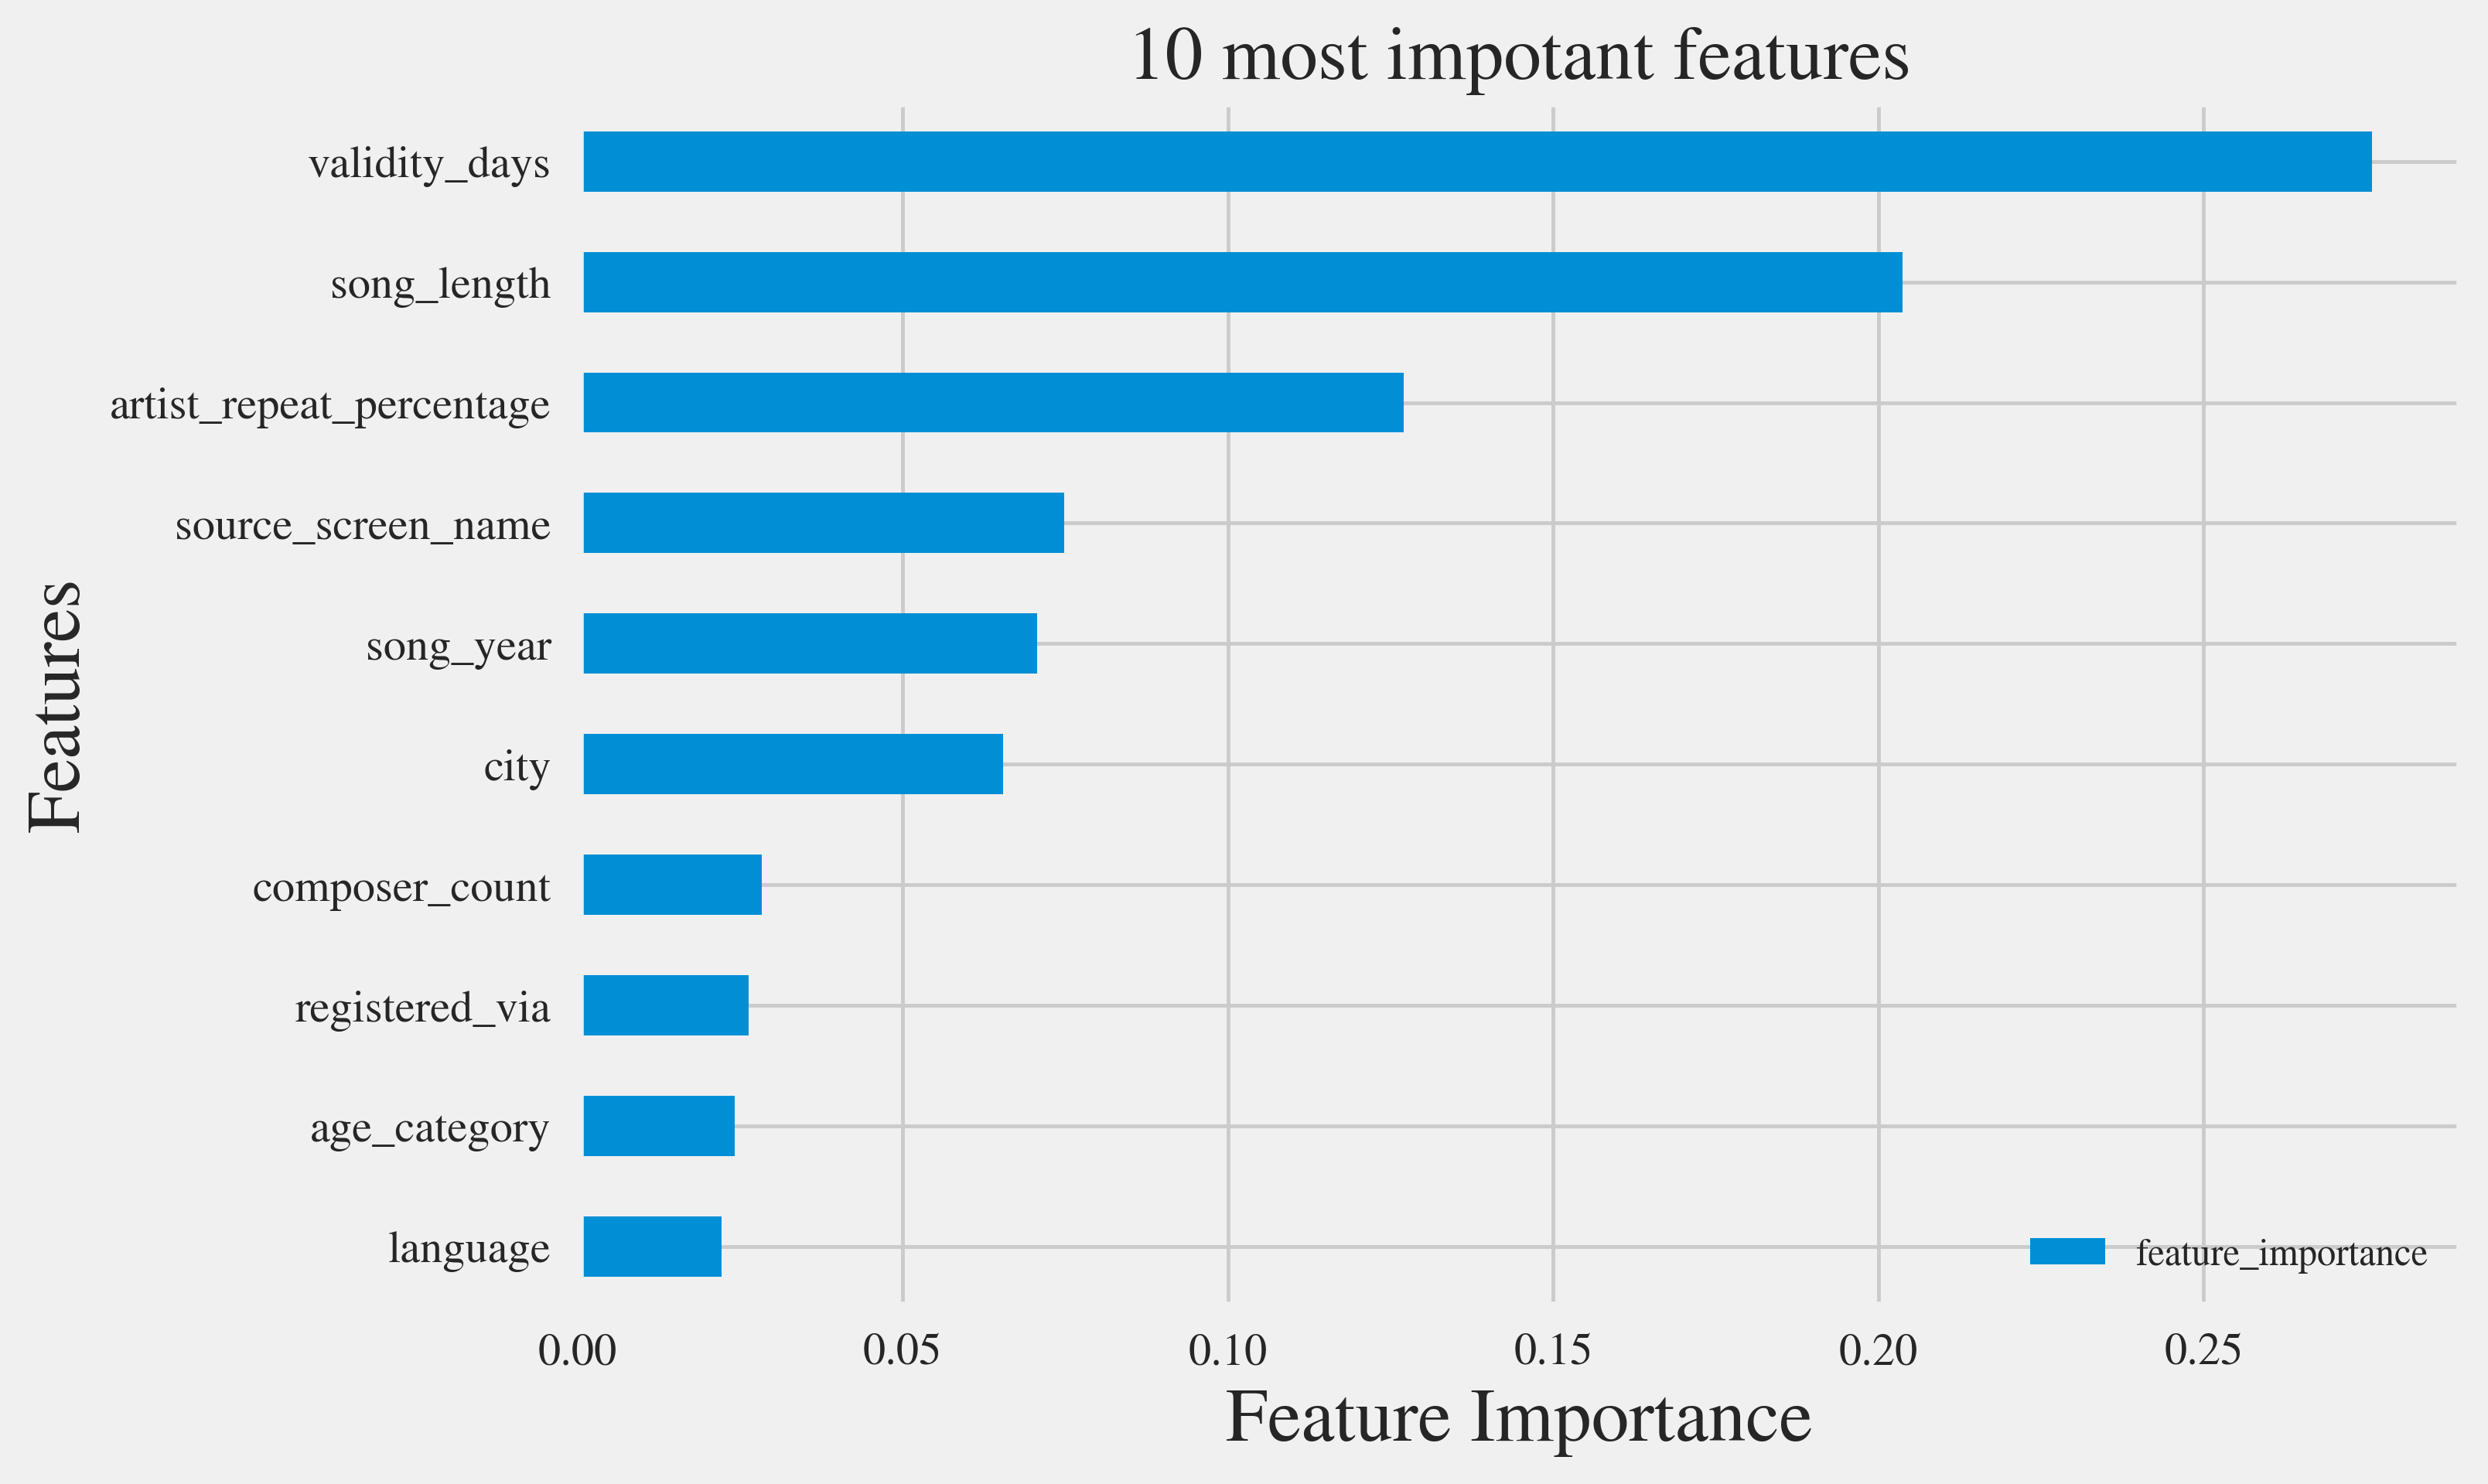

In [56]:
df_im = pd.DataFrame({'feature_importance':estimator.feature_importances_})
df_im['col'] = columns
df_im = df_im.sort_values(by='feature_importance',ascending=False)[:10]
df_im = df_im[::-1]
df_im = df_im.set_index('col', drop=True)
df_im.plot.barh(fontsize=12,label = 'feature_importance')
plt.title('10 most impotant features',fontsize=20)
plt.xlabel('Feature Importance', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.legend()
plt.show()

* The most effective feature is validity_days. It records the time range user pay for the membership. Before this, we thought the most efficient features should be age_category and repeat_percentage. From a normal perspective, it is more likely to success by recommending through age groups and artists. 
* We discussed about the reason and guessed that  it is because the time is kind of a reflection of user income. Since they willing to pay for the membership. there must be something unique in this platform, maybe some singers only publish their song on this platform, that is why the validity_days become effecitve


## LR model

In [66]:
def LR_pre(X,y,P,NFOLDS=2):
    predictions = np.zeros(len(P))
    for fold_ in range(NFOLDS):
        estimator = LogisticRegression()
        print(fold_)
        estimator.fit(X,y)
        pp_p = estimator.predict(P)
        
        predictions += pp_p/NFOLDS
    print('done')
    
    return predictions

In [54]:
from sklearn.linear_model import LogisticRegression
y_preds = LR_pre(X,y,X_test,NFOLDS=10)
result_df = pd.DataFrame()
result_df['id'] = song_ids
result_df['target'] = y_preds
result_df.to_csv('LR.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

0
1
2
3
4
5
6
7
8
9
done


## Random Forest

In [65]:
def RF_pre(X,y,P,NFOLDS=2):
    predictions = np.zeros(len(P))
    for fold_ in range(NFOLDS):
        estimator = RandomForestClassifier()
        print(fold_)
        estimator.fit(X,y)
        pp_p = estimator.predict(P)
        
        predictions += pp_p/NFOLDS
    print('done')
    
    return predictions

In [56]:
from sklearn.ensemble import RandomForestClassifier
y_preds = RF_pre(X,y,X_test,NFOLDS=10)
result_df = pd.DataFrame()
result_df['id'] = song_ids
result_df['target'] = y_preds
result_df.to_csv('RF.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

0
1
2
3
4
5
6
7
8
9
done


## use important feature

In [57]:
im_col = df_im.index.values
X = df_train[im_col].values
X_test = df_test[im_col].values

### LR

In [61]:
from sklearn.linear_model import LogisticRegression
y_preds = LR_pre(X,y,X_test,NFOLDS=10)
result_df = pd.DataFrame()
result_df['id'] = song_ids
result_df['target'] = y_preds
result_df.to_csv('LR_featured.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

0
1
2
3
4
5
6
7
8
9
done


### Decision Tree

In [63]:
from sklearn.tree import DecisionTreeClassifier
y_preds,estimator = dt_pre(X,y,X_test,NFOLDS=10)
result_df = pd.DataFrame()
result_df['id'] = song_ids
result_df['target'] = y_preds
result_df.to_csv('DT_featured.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

0
1
2
3
4
5
6
7
8
9
done


### Randomforest

In [68]:
from sklearn.ensemble import RandomForestClassifier
y_preds = RF_pre(X,y,X_test,NFOLDS=10)
result_df = pd.DataFrame()
result_df['id'] = song_ids
result_df['target'] = y_preds
result_df.to_csv('RF_featured.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

0
1
2
3
4
5
6
7
8
9
done


### Naive Bayes

In [69]:
from sklearn.naive_bayes import GaussianNB
y_preds = nb_pre(X,y,X_test,NFOLDS=10)
result_df = pd.DataFrame()
result_df['id'] = song_ids
result_df['target'] = y_preds
result_df.to_csv('NB_featured.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

0
1
2
3
4
5
6
7
8
9
done


### lightgbm

In [70]:
import lightgbm as lgb

d_train = lgb.Dataset(X, y)
watchlist = [d_train]

In [71]:
params = {}
params['learning_rate'] = 0.5
params['application'] = 'binary'
params['max_depth'] = 10
params['num_leaves'] = 2**6
params['verbosity'] = 0
params['metric'] = 'auc'

In [72]:
model = lgb.train(params, train_set=d_train, num_boost_round=100, valid_sets=watchlist, \
verbose_eval=5)

[5]	training's auc: 0.686291
[10]	training's auc: 0.691255
[15]	training's auc: 0.694743
[20]	training's auc: 0.697889
[25]	training's auc: 0.701016
[30]	training's auc: 0.703125
[35]	training's auc: 0.705207
[40]	training's auc: 0.706254
[45]	training's auc: 0.708612
[50]	training's auc: 0.710255
[55]	training's auc: 0.711974
[60]	training's auc: 0.713087
[65]	training's auc: 0.714327
[70]	training's auc: 0.715538
[75]	training's auc: 0.716343
[80]	training's auc: 0.716885
[85]	training's auc: 0.717749
[90]	training's auc: 0.718456
[95]	training's auc: 0.719325
[100]	training's auc: 0.720311


In [73]:
y_preds = model.predict(X_test)
result_df = pd.DataFrame()
result_df['id'] = song_ids
result_df['target'] = y_preds
result_df.to_csv('submission_featured.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

We record the result from kaggle competition and made this picture.

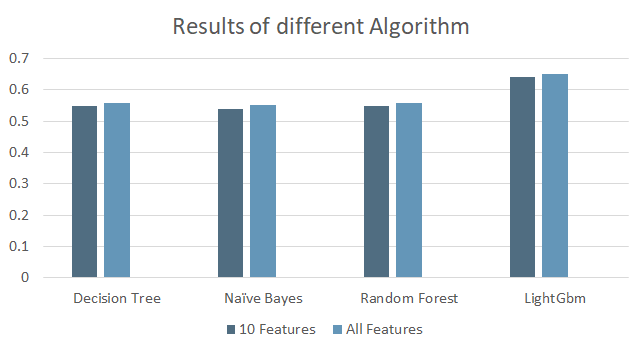

Lightgbm has the best performance among all the algorithms, and is good for processing large-scale data.  

## Reconmmended system show

In the last part of the project, we made a recommendation function.

In [25]:
y_preds = model.predict(X_test)

In [36]:
i=0
print('The precentage we recommend this song is %f, the features are:'%y_preds[i])
test_ori[i:i+1]

The precentage we recommend this song is 0.596586, the features are:


,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,224130.0,458,梁文音 (Rachel Liang),Qi Zheng Zhang,NaN,3.0,1,0,NaN,7,2016-02-19,2017-09-18


In [37]:
i+=1
print('The precentage we recommend this song is %f, the features are:'%y_preds[i])
test_ori[i:i+1]


The precentage we recommend this song is 0.667787, the features are:


,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,320470.0,465,林俊傑 (JJ Lin),林俊傑,孫燕姿/易家揚,3.0,1,0,NaN,7,2016-02-19,2017-09-18


In [38]:
i+=1
print('The precentage we recommend this song is %f, the features are:'%y_preds[i])
test_ori[i:i+1]

The precentage we recommend this song is 0.161453, the features are:


,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist,315899.0,2022,Yu Takahashi (高橋優),Yu Takahashi,Yu Takahashi,17.0,1,0,NaN,4,2016-11-17,2016-11-24


In [39]:
i+=1
print('The precentage we recommend this song is %f, the features are:'%y_preds[i])
test_ori[i:i+1]

The precentage we recommend this song is 0.160866, the features are:


,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,285210.0,465,U2,The Edge| Adam Clayton| Larry Mullen| Jr.,NaN,52.0,3,30,male,9,2007-07-25,2017-04-30


In [40]:
i+=1
print('The precentage we recommend this song is %f, the features are:'%y_preds[i])
test_ori[i:i+1]

The precentage we recommend this song is 0.156143, the features are:


,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,197590.0,873,Yoga Mr Sound,Neuromancer,NaN,-1.0,3,30,male,9,2007-07-25,2017-04-30


In [41]:
i+=1
print('The precentage we recommend this song is %f, the features are:'%y_preds[i])
test_ori[i:i+1]

The precentage we recommend this song is 0.186251, the features are:


,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
5,5,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,NV3nhEcMqsawwvSNTUAt9IVAexHLOm0lDfrHyEfN5B0=,radio,Radio,radio,216372.0,465,LEE HI,NaN,NaN,31.0,3,30,male,9,2007-07-25,2017-04-30


In [42]:
i+=1
print('The precentage we recommend this song is %f, the features are:'%y_preds[i])
test_ori[i:i+1]

The precentage we recommend this song is 0.176938, the features are:


,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
6,6,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,DPM6G9RB5QO2dvAVPyc70gxHdvu872IjTUvV6LJT8ho=,radio,Radio,radio,200306.0,465,BoA,Joe Belmaati,BoA / Joe Belmaati,31.0,3,30,male,9,2007-07-25,2017-04-30


In [43]:
i+=1
print('The precentage we recommend this song is %f, the features are:'%y_preds[i])
test_ori[i:i+1]

The precentage we recommend this song is 0.546234, the features are:


,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
7,7,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,JGXB3PHc0CX0JskwwjmYP8i318BLo7DhChgEj6Yqjt8=,my library,Local playlist more,local-playlist,344305.0,458,周傳雄 (Steve Chou),周傳雄,陳信榮,3.0,3,30,male,9,2007-07-25,2017-04-30


In [44]:
i+=1
print('The precentage we recommend this song is %f, the features are:'%y_preds[i])
test_ori[i:i+1]

The precentage we recommend this song is 0.190120, the features are:


,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
8,8,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,507plIkmke1jh3wMrHqKore82pPFozADwydR8P0Gx2Q=,radio,Radio,radio,289332.0,465,嚴藝丹 (Ivy Yan),嚴藝丹,嚴藝丹,3.0,3,30,male,9,2007-07-25,2017-04-30


In [45]:
i+=1
print('The precentage we recommend this song is %f, the features are:'%y_preds[i])
test_ori[i:i+1]

The precentage we recommend this song is 0.659160, the features are:


,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
9,9,3ZQ6oGfcSiUoCrtBPKGa8hHCiFh5jqtDqPVDUl/zrjU=,HsgJXv1C7iVZiP7CWwWTfsmMhia6Huc0MUccfj+D02o=,my library,Local playlist more,local-library,232176.0,465,BIGBANG,NaN,NaN,31.0,1,0,NaN,7,2015-12-19,2017-09-18


In [46]:
i+=1
print('The precentage we recommend this song is %f, the features are:'%y_preds[i])
test_ori[i:i+1]

The precentage we recommend this song is 0.698311, the features are:


,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
10,10,TTrLQyCfVW1KeyBqEaWeNS01cnC2ZuiezhJe2Hhqytg=,nkqjyCJ3puXlYdKN3kwPX2r2t+RT7+7II+wWA3NhEdU=,my library,Local playlist more,local-library,276688.0,465,潘瑋柏 (Will Pan),Zi Liang Lin,NaN,3.0,9,34,female,9,2009-08-07,2017-09-30


In [47]:
i+=1
print('The precentage we recommend this song is %f, the features are:'%y_preds[i])
test_ori[i:i+1]

The precentage we recommend this song is 0.364810, the features are:


,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
11,11,xerXHGjw1rQ6e9o7KCT5usAa9ejj4NAMdke7Xhnnzpc=,yCNGVHLlA+gdUm0RfeIm1xAYXFugchHvED5JVerYSWM=,discover,Online playlist more,online-playlist,253283.0,437,Hoshino Gen (星野源),星野源,星野源,17.0,22,35,male,9,2010-12-08,2017-10-09


When applying this function to solve real problems. There will be a public song list for all users. Combine the song and specific user info, it will iterate the list and return a percentage. Once the recommending percentage is over 60 percent, the current song will be added to the personal recommendation list.

# Surmmary

 Here are some solutions we think can improve the result:
* Solution 1: Split the register_date into years group.
* Solution 2: Add a language_count for artists, some artists can sing in multiple languages, different culture understanding may have positive 	influence on their songs. 
* Solution 3: Drop last 5 useless columns.

This project is to predict whether a recommended song will be repeat or not through analysising members, songs, song_extra_info, and train dataset. Lacking features in members dataset also obstruct the combining of user and songs. 
In all the prediction methods lightgbm had the best performance.Although the project is not perfect, once more features like user preference and user personality are added in features. The result can be a totally different.